In [1]:
import pandas as pd
import numpy as np
import tweepy
import requests
import re
import json
import matplotlib.pyplot as plt
import datetime
import os
import seaborn as sns
import re
from scipy import stats
%matplotlib inline

### Gathering
- archive_df
- image_predictions_df
- api_df

In [2]:
archive_df = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
file_name = url.rsplit('/', 1)[1]
r = requests.get(url, allow_redirects=True)
with open(file_name, 'wb') as f:

    f.write(r.content) 

In [4]:
image_predictions_df= pd.read_csv('image-predictions.tsv', sep='\t')
image_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [5]:
#This block will not run in the second time because the file already exists
from tweepy import OAuthHandler
from timeit import default_timer as timer
if not os.path.isfile('tweet_json.txt'):
    # Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
    # These are hidden to comply with Twitter's API terms and conditions
    consumer_key = 'HIDDEN'
    consumer_secret = 'HIDDEN'
    access_token = 'HIDDEN'
    access_secret = 'HIDDEN'

    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)

    api = tweepy.API(auth, wait_on_rate_limit=True)

    tweet_ids = df_1.tweet_id.values
    len(tweet_ids)


    count = 0
    fails_dict = {}
    start = timer()

    with open('tweet_json.txt', 'w') as outfile:
        for tweet_id in tweet_ids:
            count += 1
            print(str(count) + ": " + str(tweet_id))
            try:
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                print("Success")
                json.dump(tweet._json, outfile)
                outfile.write('\n')
            except tweepy.TweepError as e:
                print("Fail")
                fails_dict[tweet_id] = e
                pass
    end = timer()
    print(end - start)
    print(fails_dict)

In [6]:
api_df = pd.read_json('tweet_json.txt', lines=True)

### Assessing
### Visual Assessment:
#### Quality

- Representations of null values as string “none” in archive_df
- Coloumns 'timestamp', 'tweet_id' need modification in type in archive_df
- Missing data in coloumns such as 'name' which may need another api inquiry from twitter

#### Tidiness

- Dog types are stored as values in three coloumns e.g. 'pupper', 'doggo', etc.

### Programmatic Assessment:
#### Quality

- Found many occurences of 'a' string as it may have been a default name used by the text extractor in archive_df
- Existing tweets with no images, and als found retweets inside the archive that needs to be deleted
- Cleaning archive_df from all retweets, replies and ratings that doesn't have pictures
- Removing unrelated and empty columns in api_df, and renaming the coloum 'id' to 'tweet_id', and mergin the api_df with archive_df
- Removing unnecessary coloumns from archive_df using drop method
- columns in image_predictions_df are value names and not variable names in p1, p2, p3 and choosing which prediction fit the image

#### Tidiness
- Merge the three datasets into one master dataframe

In [7]:
archive_df.info()
archive_df[archive_df['name']=='a']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,None,None,pupper,None
649,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a perfect example of someone who has t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/792913359...,13,10,a,None,None,None,None
801,772581559778025472,NaN,NaN,2016-09-04 23:46:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Guys this is getting so out of hand. We only r...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/772581559...,10,10,a,None,None,None,None
1002,747885874273214464,NaN,NaN,2016-06-28 20:14:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a mighty rare blue-tailed hammer sherk...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747885874...,8,10,a,None,None,None,None
1004,747816857231626240,NaN,NaN,2016-06-28 15:40:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Viewer discretion is advised. This is a terrib...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747816857...,4,10,a,None,None,None,None
1017,746872823977771008,NaN,NaN,2016-06-26 01:08:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a carrot. We only rate dogs. Please on...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/746872823...,11,10,a,None,None,None,None
1049,743222593470234624,NaN,NaN,2016-06-15 23:24:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a very rare Great Alaskan Bush Pupper....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/743222593...,12,10,a,None,None,pupper,None
1193,717537687239008257,NaN,NaN,2016-04-06 02:21:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",People please. This is a Deadly Mediterranean ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/717537687...,11,10,a,None,None,None,None
1207,715733265223708672,NaN,NaN,2016-04-01 02:51:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a taco. We only rate dogs. Please only...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/715733265...,10,10,a,None,None,None,None
1340,704859558691414016,NaN,NaN,2016-03-02 02:43:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a heartbreaking scene of an incredible...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/704859558...,10,10,a,None,None,pupper,None


In [8]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2354 non-null   datetime64[ns, UTC]
 1   id                             2354 non-null   int64              
 2   id_str                         2354 non-null   int64              
 3   full_text                      2354 non-null   object             
 4   truncated                      2354 non-null   bool               
 5   display_text_range             2354 non-null   object             
 6   entities                       2354 non-null   object             
 7   extended_entities              2073 non-null   object             
 8   source                         2354 non-null   object             
 9   in_reply_to_status_id          78 non-null     float64            
 10  in_reply_to_status_id_st

In [9]:
api_df.favorited.value_counts()

False    2346
True        8
Name: favorited, dtype: int64

In [10]:
image_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [11]:
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [12]:
image_predictions_df[image_predictions_df['p1_dog'] == False]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,0.015250,False,great_grey_owl,0.013207,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2026,882045870035918850,https://pbs.twimg.com/media/DD2oCl2WAAEI_4a.jpg,1,web_site,0.949591,False,dhole,0.017326,False,golden_retriever,0.006941,True
2046,886680336477933568,https://pbs.twimg.com/media/DE4fEDzWAAAyHMM.jpg,1,convertible,0.738995,False,sports_car,0.139952,False,car_wheel,0.044173,False
2052,887517139158093824,https://pbs.twimg.com/ext_tw_video_thumb/88751...,1,limousine,0.130432,False,tow_truck,0.029175,False,shopping_cart,0.026321,False
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False


In [13]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2354 non-null   datetime64[ns, UTC]
 1   id                             2354 non-null   int64              
 2   id_str                         2354 non-null   int64              
 3   full_text                      2354 non-null   object             
 4   truncated                      2354 non-null   bool               
 5   display_text_range             2354 non-null   object             
 6   entities                       2354 non-null   object             
 7   extended_entities              2073 non-null   object             
 8   source                         2354 non-null   object             
 9   in_reply_to_status_id          78 non-null     float64            
 10  in_reply_to_status_id_st

## Cleaning
### Define
Changing 'None' string values with Nan values using replace method

### Code

In [14]:
archive_df_clean = archive_df.copy()

In [15]:
archive_df_clean.replace('None', np.nan, inplace=True)

### Test

In [16]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        1611 non-null   object 
 13  doggo                       97 no

### Define
Cleaning archive_df from all retweets, replies and ratings that doesn't have pictures

### Code

In [17]:
replies_df = archive_df_clean[archive_df_clean['in_reply_to_status_id'].notnull()]
retweets_df = archive_df_clean[archive_df_clean['retweeted_status_id'].notnull()]
noimages_df = archive_df_clean[archive_df_clean['expanded_urls'].notnull()]

In [18]:
archive_df_clean = pd.concat([archive_df_clean, replies_df]).drop_duplicates(keep=False)
archive_df_clean = pd.concat([archive_df_clean, retweets_df]).drop_duplicates(keep=False)

### Test

In [19]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2097 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   2097 non-null   object 
 4   source                      2097 non-null   object 
 5   text                        2097 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2094 non-null   object 
 10  rating_numerator            2097 non-null   int64  
 11  rating_denominator          2097 non-null   int64  
 12  name                        1494 non-null   object 
 13  doggo                       83 no

### Define
Changing 'a' string and replacing it with a np.nan values

### Code

In [20]:
archive_df_clean['name'].replace('a', np.nan, inplace=True)

### Test

In [21]:
archive_df_clean.name.value_counts()

Lucy       11
Charlie    11
Oliver     10
Cooper     10
Penny       9
           ..
Jordy       1
Pipsy       1
Jerome      1
Nigel       1
Josep       1
Name: name, Length: 953, dtype: int64

### Define
Melting three coloumns with dog types into one variable coloumn dog_stage

### Code

In [22]:
dog_types = pd.melt(archive_df_clean, id_vars=['tweet_id'] , value_vars= ['doggo', 'floofer', 'pupper', 'puppo'], value_name= 'dog_stage')

In [23]:
dog_types = dog_types[dog_types.dog_stage.notnull()]
dog_types.loc[dog_types.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo, pupper'
dog_types.loc[dog_types.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo, puppo'
dog_types.loc[dog_types.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo, floofer'

In [24]:
dog_types.drop(labels= ['variable'], axis= 1)

,tweet_id,dog_stage
9,890240255349198849,doggo
39,884162670584377345,doggo
86,872967104147763200,doggo
94,871515927908634625,doggo
95,871102520638267392,doggo
...,...,...
7031,752519690950500352,puppo
7044,751132876104687617,puppo
7112,744995568523612160,puppo
7124,743253157753532416,puppo


In [25]:
archive_df_clean= archive_df_clean.join(dog_types.set_index('tweet_id'), on='tweet_id')

### Test

In [26]:
archive_df_clean.dog_stage.value_counts()

pupper     230
doggo       83
puppo       24
floofer     10
Name: dog_stage, dtype: int64

### Define
Dropping unnecessary coloumns from archive_df using drop method

### Code

In [27]:
archive_df_clean =archive_df_clean.drop(labels= ['variable', 'doggo', 'floofer', 'pupper', 'puppo', 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'timestamp'], axis= 1)

### Test

In [28]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2108 entries, 0 to 2355
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2108 non-null   int64 
 1   source              2108 non-null   object
 2   text                2108 non-null   object
 3   expanded_urls       2105 non-null   object
 4   rating_numerator    2108 non-null   int64 
 5   rating_denominator  2108 non-null   int64 
 6   name                1444 non-null   object
 7   dog_stage           347 non-null    object
dtypes: int64(3), object(5)
memory usage: 148.2+ KB


### Define
Removing unrelated columns in api_df, and renaming the coloum 'id' to 'tweet_id', and mergin the api_df with archive_df

### Code

In [29]:
trial = archive_df_clean.copy()
api_df.rename(columns={'id':'tweet_id'}, inplace=True)
api_df = api_df[['created_at', 'tweet_id', 'favorite_count', 'retweet_count']]
archive_df_clean = archive_df_clean.merge(api_df, on='tweet_id')

### Test

In [30]:
archive_df_clean.info()
archive_df_clean.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2108 entries, 0 to 2107
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2108 non-null   int64              
 1   source              2108 non-null   object             
 2   text                2108 non-null   object             
 3   expanded_urls       2105 non-null   object             
 4   rating_numerator    2108 non-null   int64              
 5   rating_denominator  2108 non-null   int64              
 6   name                1444 non-null   object             
 7   dog_stage           347 non-null    object             
 8   created_at          2108 non-null   datetime64[ns, UTC]
 9   favorite_count      2108 non-null   int64              
 10  retweet_count       2108 non-null   int64              
dtypes: datetime64[ns, UTC](1), int64(5), object(5)
memory usage: 197.6+ KB


,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,created_at,favorite_count,retweet_count
0,892420643555336193,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,2017-08-01 16:23:56+00:00,39467,8853
1,892177421306343426,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,2017-08-01 00:17:27+00:00,33819,6514
2,891815181378084864,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,2017-07-31 00:18:03+00:00,25461,4328
3,891689557279858688,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,2017-07-30 15:58:51+00:00,42908,8964
4,891327558926688256,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,2017-07-29 16:00:24+00:00,41048,9774


### Define
Finding the most accurate image predictions for the dog breed and using the final correct prediction and link it with the tweets

### Code

In [31]:
image_predictions_df.loc[(image_predictions_df['p1_dog'] == True), 'breed_pred' ] = image_predictions_df['p1'] 
image_predictions_df.loc[(image_predictions_df['p1_dog'] == False) & image_predictions_df['p2_dog']==True, 'breed_pred' ] = image_predictions_df['p2']
image_predictions_df.loc[(image_predictions_df['p1_dog'] == False) & (image_predictions_df['p2_dog']==False) & (image_predictions_df['p3_dog']==True), 'breed_pred' ] = image_predictions_df['p3']
image_predictions_df.loc[(image_predictions_df['p1_dog'] == False) & (image_predictions_df['p2_dog']==False) & (image_predictions_df['p3_dog']==False), 'breed_pred' ] = 'Couldn\'t predict'

In [32]:
image_predictions_clean = image_predictions_df[['tweet_id', 'breed_pred']]
archive_df_clean = archive_df_clean.merge(image_predictions_clean, on='tweet_id')

 ### Test

In [33]:
image_predictions_df.breed_pred.value_counts()

Couldn't predict      324
golden_retriever      173
Labrador_retriever    113
Pembroke               96
Chihuahua              95
                     ... 
silky_terrier           1
clumber                 1
EntleBucher             1
Irish_wolfhound         1
Japanese_spaniel        1
Name: breed_pred, Length: 114, dtype: int64

In [34]:
archive_df_clean.info()
archive_df_clean.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1981 entries, 0 to 1980
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1981 non-null   int64              
 1   source              1981 non-null   object             
 2   text                1981 non-null   object             
 3   expanded_urls       1981 non-null   object             
 4   rating_numerator    1981 non-null   int64              
 5   rating_denominator  1981 non-null   int64              
 6   name                1397 non-null   object             
 7   dog_stage           313 non-null    object             
 8   created_at          1981 non-null   datetime64[ns, UTC]
 9   favorite_count      1981 non-null   int64              
 10  retweet_count       1981 non-null   int64              
 11  breed_pred          1981 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(5

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,created_at,favorite_count,retweet_count,breed_pred
0,892420643555336193,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,2017-08-01 16:23:56+00:00,39467,8853,Couldn't predict
1,892177421306343426,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,2017-08-01 00:17:27+00:00,33819,6514,Chihuahua
2,891815181378084864,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,2017-07-31 00:18:03+00:00,25461,4328,Chihuahua
3,891689557279858688,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,2017-07-30 15:58:51+00:00,42908,8964,Labrador_retriever
4,891327558926688256,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,2017-07-29 16:00:24+00:00,41048,9774,basset


## Storing and visualization
### Storing

In [35]:
archive_df_clean.to_csv(path_or_buf=r'D:\FWD\twitter wrangle\twitter_archive_master.csv')

### Insights
- We can notice how on average the number of favorites for the dog breeds are sorted out, we can discover from this the most loveable for the dog owners community online.

In [36]:
archive_df_clean.groupby('breed_pred')['favorite_count'].mean().sort_values(ascending=False)

breed_pred
Saluki                   24060.000000
Bedlington_terrier       21153.166667
flat-coated_retriever    20241.888889
French_bulldog           18416.806452
Bouvier_des_Flandres     18032.000000
                             ...     
Tibetan_terrier           1841.000000
Irish_wolfhound           1534.000000
Japanese_spaniel          1362.000000
groenendael               1156.500000
Brabancon_griffon          885.000000
Name: favorite_count, Length: 114, dtype: float64

- See how a hidden relation between the WeRateDogs ratings and their usage of names like 'pupper', 'doggo', etc.

In [37]:
archive_df_clean.groupby('dog_stage')['rating_numerator'].mean().sort_values(ascending=False)

dog_stage
puppo      12.043478
floofer    11.875000
doggo      11.794521
pupper     10.727273
Name: rating_numerator, dtype: float64

- Plotting the top 10 dog names that got retweeted the most, showing the retweets number for each name

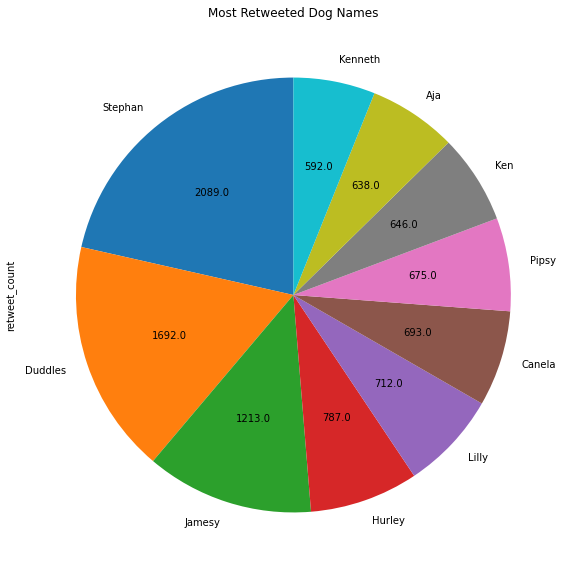

In [38]:
sizes = np.array([5860, 677, 3200])
def absolute_value(val):
    a  = np.round(val/100.*sizes.sum(), 0)
    return a
archive_df_clean.groupby('name')['retweet_count'].mean().sort_values(ascending=False).iloc[:10].plot(kind='pie', figsize=(10, 10), title='Most Retweeted Dog Names', startangle=90, autopct=absolute_value)
